In [1]:
from transformers import AutoTokenizer
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()
tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")

tok.eos_token_id

/home/dev371/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2

In [2]:
#!pip install -q librosa soundfile transformers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import os, numpy as np, tensorflow as tf, librosa, soundfile as sf
from IPython.display import Audio, display
from transformers import AutoTokenizer

# لاگ‌های اضافی کمتر
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
for gpu in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(gpu, True)
    except: pass


2025-10-23 02:47:29.864399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761175049.876017 2704283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761175049.879606 2704283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761175049.889171 2704283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761175049.889180 2704283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761175049.889182 2704283 computation_placer.cc:177] computation placer alr

In [3]:
from MyTTSModel import TransformerTTS  # همان فایلی که مدل TTS را نوشتی
import os

# پارامترها باید با آموزش هم‌خوانی داشته باشند
SR          = 16000
N_FFT       = 1024
HOP         = 256
WIN         = 1024
N_MELS      = 80
FMIN        = 0.0
FMAX        = 8000.0
MAX_SRC_LEN = 256
MAX_MEL_LEN = 2000  # سقف منطقی برای تولید

# توکنایزر NLLB (فعلاً انگلیسی)
tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")
PAD_ID = tok.pad_token_id

# ساخت/لود مدل
core = TransformerTTS(
    num_layers=12, d_model=256, num_heads=8, dff=2024,
    input_vocab_size=len(tok), n_mels=N_MELS,
    dropout_rate=0.1, pad_id=PAD_ID
)

core.build_for_load(max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_MEL_LEN)
# وزن‌های آموزش‌داده‌شده‌ات (اولویت با EMA)
os.makedirs("checkpoints", exist_ok=True)
core_path = "checkpoints/tts_core_ema_last.weights.h5"
if not os.path.exists(core_path):
    core_path = "checkpoints/tts_core_last.weights.h5"

if os.path.exists(core_path):
    try:
        core.load_weights(core_path)
        print("✅ Weights loaded.")
    except Exception as e:
        print("⚠️ Strict load failed:", e)
        try:
            core.load_weights(core_path, skip_mismatch=True)
            print("✅ Weights loaded (skip_mismatch).")
        except Exception as e2:
            print("⚠️ Fallback load failed:", e2)
else:
    print("⚠️ Checkpoint not found:", core_path)


/home/dev371/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
I0000 00:00:1761175053.795428 2704283 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:4e:00.0, compute capability: 8.9


Model: "TransformerTTS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │    81,221,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ tokpos                     │ ?                      │    65,588,224 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_0 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_2 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_3 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_4 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_5 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_6 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_7 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_8 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_9 (EncoderLayer)     │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_10 (EncoderLayer)    │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_11 (EncoderLayer)    │ ?                      │     1,302,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (DecoderTTS)            │ ?                      │    18,949,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ melpos                     │ ?                      │       152,320 │
│ (MelPositionalProjection)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_0 (DecoderLayer)     │ ?                      │     1,566,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1 (DecoderLayer)     │ ?                      │     1,566,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_2 (DecoderLayer)     │ ?                      │     1,566,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_3 (DecoderLayer)     │ ?                      │     1,566,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_4 (DecoderLayer)     │ ?                      │     1,566,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_5 (DecoderLayer)     │ ?                      │     1,566,44

 Total params: 104,544,241 (398.80 MB)

 Trainable params: 104,539,985 (398.79 MB)

 Non-trainable params: 4,256 (16.62 KB)

⚠️ Strict load failed: A total of 256 objects could not be loaded. Example error message for object <Dense name=dense_2, built=True>:

Layer 'dense_2' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense_2, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <LayerNormalization name=ln, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <LayerNormalization name=ln, built=True>, <LayerNormalization name=ln, built=True>, <Dense name=fc1, built=True>, <Dense name=fc2, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <LayerNorm

✅ Weights loaded (skip_mismatch).


/home/dev371/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:648: UserWarning: A total of 256 objects could not be loaded. Example error message for object <Dense name=dense_2, built=True>:

Layer 'dense_2' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Dense name=dense_2, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <LayerNormalization name=ln, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDense name=query, built=True>, <EinsumDense name=value, built=True>, <LayerNormalization name=ln, built=True>, <LayerNormalization name=ln, built=True>, <Dense name=fc1, built=True>, <Dense name=fc2, built=True>, <EinsumDense name=key, built=True>, <EinsumDense name=attention_output, built=True>, <EinsumDens

In [4]:
# ---------- کمکـی‌ها برای برگرداندن mel_norm[-1,1] به موج ----------
def db_to_power(db): return tf.pow(10.0, db / 10.0)

def denorm_mel(mel_norm):
    mel01  = (mel_norm + 1.0) * 0.5        # [-1,1] -> [0,1]
    mel_db = mel01 * 100.0 - 100.0         # -> [-100, 0] dB
    return db_to_power(mel_db)             # -> power

def mel_to_linear_power(mel_power, sr=SR, n_fft=N_FFT, n_mels=N_MELS, fmin=FMIN, fmax=FMAX):
    mel_mat = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=n_fft // 2 + 1,
        sample_rate=float(sr),
        lower_edge_hertz=float(fmin),
        upper_edge_hertz=float(fmax),
        dtype=tf.float32
    )  # (n_fft//2+1, n_mels)
    mel_pinv = tf.linalg.pinv(mel_mat)               # (n_mels, n_fft//2+1)
    linear_power = tf.matmul(mel_power, mel_pinv)    # (T, n_fft//2+1)
    return tf.maximum(linear_power, 1e-10)

def griffin_lim_from_mag(mag, n_fft=N_FFT, hop=HOP, win=WIN, n_iter=60):
    mag = tf.cast(mag, tf.float32)

    # --- init random phase (بدون 1j) ---
    phases = tf.random.uniform(tf.shape(mag), 0.0, 2.0*np.pi, dtype=tf.float32)
    angles = tf.complex(tf.cos(phases), tf.sin(phases))            # (T, n_fft//2+1) complex64
    S = tf.cast(mag, tf.complex64) * angles

    def _stft(w):
        return tf.signal.stft(w, frame_length=win, frame_step=hop,
                              fft_length=n_fft, window_fn=tf.signal.hann_window)
    def _istft(S_):
        return tf.signal.inverse_stft(S_, frame_length=win, frame_step=hop,
                                      window_fn=tf.signal.hann_window)

    for _ in range(n_iter):
        wav = _istft(S)
        S_est = _stft(wav)
        ang = tf.math.angle(S_est)                                 # float32
        phase = tf.complex(tf.cos(ang), tf.sin(ang))               # complex64
        S = tf.cast(mag, tf.complex64) * phase

    wav = _istft(S)
    wav = wav / (tf.reduce_max(tf.abs(wav)) + 1e-6)                # [-1,1]
    return tf.squeeze(wav)


def mel_to_wav_griffinlim(mel_norm, n_iter=60):
    mel_power = denorm_mel(mel_norm)
    linear_power = mel_to_linear_power(mel_power)
    mag = tf.sqrt(tf.maximum(linear_power, 1e-10))
    return griffin_lim_from_mag(mag, n_iter=n_iter)

# ---------- مدل و توکنایزر ----------
# فرض: core همون TransformerTTS شماست که build شده و وزن‌هاش لود شدن
# core.load_weights("checkpoints/tts_core_best.weights.h5")

tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")

def tokenize_texts(texts, tok, max_len=256, pad_id=1):
    ids = [tok.encode(t, add_special_tokens=True, src_lang="eng_Latn")[:max_len] for t in texts]
    lens = [len(x) for x in ids]
    ids_pad = tf.keras.preprocessing.sequence.pad_sequences(ids, maxlen=max_len, padding="post", value=pad_id)
    return tf.constant(ids_pad, tf.int32), tf.constant(lens, tf.int32)



# (اختیاری) ذخیره‌ی WAV روی دیسک
# tf.io.write_file("tts_out.wav", tf.audio.encode_wav(tf.expand_dims(wav, -1), sample_rate=SR))

In [5]:
# ---------- اینفرنس ----------
texts = ["Please use our dedicated channels for questions and discussion"]
enc_ids, _ = tokenize_texts(texts, tok, max_len=MAX_SRC_LEN, pad_id=PAD_ID)

# greedy_generate شما خروجی PostNet را برمی‌گرداند (mel_hat)
mel_hat, stop_probs = core.greedy_generate_fast(
    enc_ids,
    max_steps=600,      # برای تست، بعداً زیاد کن
    min_steps=40,
    stop_threshold=0.55,
    window=6,
    patience=2,
    check_stop_every=10,
    verbose=True
)
mel_one = mel_hat[0].numpy()
wav = mel_to_wav_griffinlim(mel_one, n_iter=32)  # قبلاً 64 یا 60 بود
Audio(wav.numpy(), rate=SR)

/home/dev371/.local/lib/python3.10/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


gen step 50 stop~ 0.979992092
[stop @ step 70]


I0000 00:00:1761175084.405695 2704283 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1761175085.612641 2704283 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x62a2c8a42c50


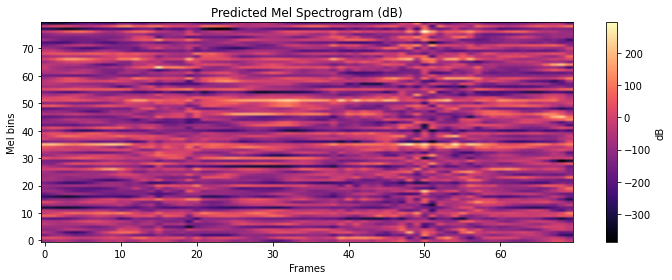

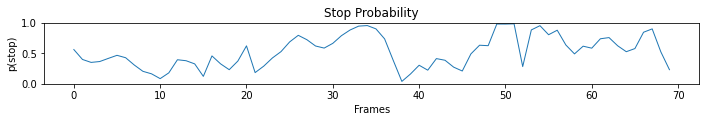

In [6]:
# ---------- Visualization: Mel spectrogram + Stop probability ----------
import matplotlib.pyplot as plt

def mel_norm_to_db(m):
    """Convert normalized mel [-1,1] to dB [-100,0].
    """
    return ((m + 1.0) * 0.5) * 100.0 - 100.0

# Plot mel in dB
mel_db = mel_norm_to_db(mel_one)
plt.figure(figsize=(10, 4))
plt.imshow(mel_db.T, origin='lower', aspect='auto', cmap='magma')
cbar = plt.colorbar(); cbar.set_label('dB')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.title('Predicted Mel Spectrogram (dB)')
plt.tight_layout()
plt.show()

# Plot stop probability over time (if available)
try:
    sp = stop_probs[0].numpy().squeeze()
    plt.figure(figsize=(10, 1.8))
    plt.plot(sp, linewidth=1.0)
    plt.ylim([0, 1])
    plt.xlabel('Frames')
    plt.ylabel('p(stop)')
    plt.title('Stop Probability')
    plt.tight_layout()
    plt.show()
except Exception:
    pass
